c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


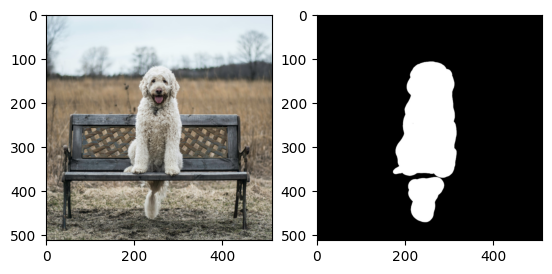

In [1]:
import torch
import requests
from io import BytesIO
from matplotlib import pyplot as plt
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
import glob

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using device: {device}")


# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))
plt.subplot(1,2,1)
plt.imshow(init_image)
plt.subplot(1,2,2)
plt.imshow(mask_image)

In [2]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  9.98it/s]


c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 35/35 [00:08<00:00,  4.01it/s]


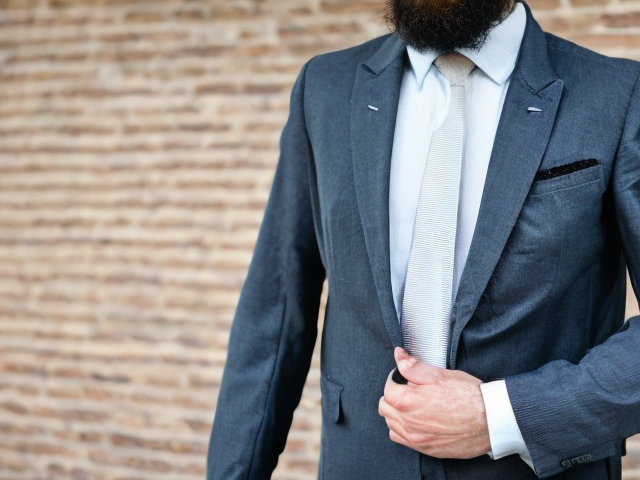

In [3]:
# Set up a generator for reproducibility
# generator = torch.Generator(device=device).manual_seed(42)
generator = torch.Generator(device=device)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="a man with a beard and a suit jackett",  # What to generate
    # negative_prompt="Oversaturated, blurry, low quality",  # What NOT to generate
    height=480,
    width=640,  # Specify the image size
    guidance_scale=8,  # How strongly to follow the prompt
    num_inference_steps=35,  # How many steps to take
    generator=generator,  # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

Finetuning

In [3]:
IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"]

In [4]:
# # Define Text2ImageDataset class

# class Text2ImageDataset(torch.utils.data.Dataset):
#     """
#     (1) Goal:
#         - This class is used to build dataset for finetuning text-to-image model

#     """
#     def __init__(self, images_folder, captions_folder, transform, tokenizer):
#         """
#         (2) Arguments:
#             - images_folder: str, path to images
#             - captions_folder: str, path to captions
#             - transform: function, turn raw image into torch.tensor
#             - tokenizer: CLIPTokenize, turn sentences into word ids
#         """
#         self.image_paths = []
#         for root, _, files in os.walk(images_folder):
#             for file in files:
#                 if any(file.endswith(ext) for ext in IMAGE_EXTENSIONS):
#                     self.image_paths.append(os.path.join(root, file))
#         self.image_paths = sorted(self.image_paths)

#         caption_paths = []
#         for root, _, files in os.walk(captions_folder):
#             for file in files:
#                 if file.endswith(".txt"):
#                     caption_paths.append(os.path.join(root, file))
#         caption_paths = sorted(caption_paths)
        
#         captions = []
#         for p in caption_paths:
#             with open(p, "r") as f:
#                 captions.append(f.readline().strip())
        
#         inputs = tokenizer(
#             captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
#         )
        
#         self.input_ids = inputs.input_ids
#         self.transform = transform

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         input_id = self.input_ids[idx]
#         try:
#             image = cv2.imread(img_path)
#             if image is None:
#                 raise ValueError(f"Image at path {img_path} could not be read, possibly due to incorrect file path or unsupported format.")
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             tensor = self.transform(image)
#         except Exception as e:
#             print(f"Could not load image path: {img_path}, error: {e}")
#             return None

#         return tensor, input_id


#     def __len__(self):
#         return len(self.image_paths)


class Text2ImageDataset(torch.utils.data.Dataset):
    """
    (1) Goal:
        - This class is used to build dataset for finetuning text-to-image model

    """
    def __init__(self, images_folder, captions_folder, transform, tokenizer):
        """
        (2) Arguments:
            - images_folder: str, path to images
            - captions_folder: str, path to captions
            - transform: function, turn raw image into torch.tensor
            - tokenizer: CLIPTokenize, turn sentences into word ids
        """
        self.image_paths = []
        for ext in IMAGE_EXTENSIONS:
            self.image_paths.extend(glob.glob(f"{images_folder}/*{ext}"))
        self.image_paths = sorted(self.image_paths)
        caption_paths = sorted(glob.glob(f"{captions_folder}/*txt"))
        captions = []
        for p in caption_paths:
            with open(p, "r") as f:
                captions.append(f.readline())
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        self.input_ids = inputs.input_ids
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        input_id = self.input_ids[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            # convert to tensor temporarily so dataloader will accept it
            tensor = self.transform(image)
        except Exception as e:
            print(f"Could not load image path: {img_path}, error: {e}")
            return None


        return tensor, input_id

    def __len__(self):
        return len(self.image_paths)

In [5]:
# Define LORA Layer
class LoRALayer(nn.Module):
    def __init__(self, input_dim, rank):
        super(LoRALayer, self).__init__()
        self.rank = rank
        self.down_proj = nn.Linear(input_dim, rank, bias=False)
        self.up_proj = nn.Linear(rank, input_dim, bias=False)

    def forward(self, x):
        return self.up_proj(self.down_proj(x))


In [6]:
# Apply LORA to the existing model
class LoRAModel(nn.Module):
    def __init__(self, base_model, lora_rank=4):
        super(LoRAModel, self).__init__()
        self.base_model = base_model
        self.lora_layers = nn.ModuleList()
        for name, param in base_model.named_parameters():
            if 'attention' in name and 'query' in name:  # Example: Add LoRA to attention query layers
                input_dim = param.size(1)  # Assuming param shape is (out_dim, in_dim)
                self.lora_layers.append(LoRALayer(input_dim, lora_rank))

    def forward(self, x):
        for i, (name, param) in enumerate(self.base_model.named_parameters()):
            if 'attention' in name and 'query' in name:
                x = x + self.lora_layers[i](x)
        return x

In [7]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [9]:
# Dataset and DataLoader
images_folder = "stable_diffusion_finetuning\Datasets\Brad"
captions_folder = "stable_diffusion_finetuning\Datasets\Brad"
dataset = Text2ImageDataset(images_folder, captions_folder, transform, tokenizer)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize LoRA model
lora_model = LoRAModel(pipe.unet).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lora_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    lora_model.train()
    total_loss = 0
    
    for batch_idx, (images, input_ids) in enumerate(dataloader):
        images = images.to(device).float()  # Ensure images are float tensors
        images.requires_grad = True  # Ensure images require gradients
        input_ids = input_ids.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass through the LoRA model
        noise_pred = lora_model(images)
        
        # Calculate loss
        loss = criterion(noise_pred, images)  # Simplified loss, you might need to adapt this
        
        # Check for requires_grad
        assert loss.requires_grad, "Loss does not require gradients. Check the forward pass."
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss / len(dataloader):.4f}")


# Save the finetuned model
save_path = "lora_finetuned_model.pt"
torch.save(lora_model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Epoch [1/10], Step [1/25], Loss: 0.0000
Epoch [1/10], Step [11/25], Loss: 0.0000
Epoch [1/10], Step [21/25], Loss: 0.0000
Epoch [1/10] Loss: 0.0000
Epoch [2/10], Step [1/25], Loss: 0.0000
Epoch [2/10], Step [11/25], Loss: 0.0000
Epoch [2/10], Step [21/25], Loss: 0.0000
Epoch [2/10] Loss: 0.0000
Epoch [3/10], Step [1/25], Loss: 0.0000
Epoch [3/10], Step [11/25], Loss: 0.0000
Epoch [3/10], Step [21/25], Loss: 0.0000
Epoch [3/10] Loss: 0.0000
Epoch [4/10], Step [1/25], Loss: 0.0000
Epoch [4/10], Step [11/25], Loss: 0.0000
Epoch [4/10], Step [21/25], Loss: 0.0000
Epoch [4/10] Loss: 0.0000
Epoch [5/10], Step [1/25], Loss: 0.0000
Epoch [5/10], Step [11/25], Loss: 0.0000
Epoch [5/10], Step [21/25], Loss: 0.0000
Epoch [5/10] Loss: 0.0000
Epoch [6/10], Step [1/25], Loss: 0.0000
Epoch [6/10], Step [11/25], Loss: 0.0000
Epoch [6/10], Step [21/25], Loss: 0.0000
Epoch [6/10] Loss: 0.0000
Epoch [7/10], Step [1/25], Loss: 0.0000
Epoch [7/10], Step [11/25], Loss: 0.0000
Epoch [7/10], Step [21/25], Los

In [11]:

# Load the finetuned model for inference
loaded_lora_model = LoRAModel(pipe.unet).to(device)
loaded_lora_model.load_state_dict(torch.load(save_path))
loaded_lora_model.eval()

# Inference using text prompt
def run_text_to_image_inference(model, text_prompt):
    """
    Generate an image based on a text prompt.
    
    Args:
        model: The loaded LoRA fine-tuned model.
        text_prompt (str): The text prompt for image generation.
    
    Returns:
        Generated image.
    """
    # Tokenize the input text
    inputs = tokenizer([text_prompt], max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    
    # Pass the tokenized text into the model
    with torch.no_grad():
        # Run inference
        generated_images = pipe(prompt=text_prompt, num_images_per_prompt=1).images
    
    return generated_images[0]  # Return the first generated image


# Example usage
text_prompt = "a man with a beard and a suit jackett"
generated_image = run_text_to_image_inference(pipe, text_prompt)

# Save the image
generated_image.save("generated_image.png")
print("Image saved as 'generated_image.png'")


C:\Users\Wenbzhan\AppData\Local\Temp\ipykernel_296980\102456387.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_lora_model.load_state_dict(torch.load(save_path))


Image saved as 'generated_image.png'
